# Metric learning embeddings clustering via KNN

In [1]:
%load_ext autoreload
%autoreload 2

%env CUDA_VISIBLE_DEVICES 7

env: CUDA_VISIBLE_DEVICES=7


Import necessary tools.

In [2]:
import sys

sys.path.insert(0, '../batchflow')
sys.path.insert(0, '../src')
sys.path.insert(0, '../open-metric-learning')

import numpy as np
import pandas as pd
from torchvision import transforms
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import torch
from torch.utils.data import Dataset, DataLoader
from oml.datasets.base import DatasetWithLabels
from oml.utils.images.images import imread_pillow

from torchvision.models import efficientnet_b2
from nbtools.core import get_notebook_name

from batchflow import plot, Notifier

from loader import ImagesDataset
from evaluator import MetricsEvaluator

Get notebook name and use it as an experiment name.

In [3]:
NAME = get_notebook_name()
NAME

'07_EFFICIENTNET+KNN'

Define seed for reproducibility.

In [4]:
SEED = 11
rng = np.random.default_rng(SEED)
generator = torch.Generator()
generator = generator.manual_seed(SEED)

Load data but in slightly different manner, since we're working with torch directly, without fancy batchflow abstractions.

In [5]:
DATA_PATH = '../images'
SHAPE = (128, 128)

names, inputs, labels = ImagesDataset.load(DATA_PATH)
labels, label_encoder = ImagesDataset.encode(labels)
classes = label_encoder.classes_.tolist()
n_classes = len(classes)

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 405.18it/s]


Define simple preprocessing, consisting of tensor conversion, image resize and normalization. Actually, all the same as previously, just with different tool.

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=SHAPE),
    transforms.Normalize(mean=(0.527, 0.484, 0.423), std=(0.267, 0.258, 0.260))
])

Load data.

In [7]:
dataframe = pd.DataFrame({'path': inputs, 'label': labels})
dataset = DatasetWithLabels(dataframe, dataset_root='.', transform=transform, f_imread=imread_pillow)

BATCH_SIZE = 128
loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, generator=generator)

Load trained model.

In [8]:
%%time

DEVICE = 'cuda:0'
MODEL_PATH = '../models/05_EFFICIENTNET.state'

model = efficientnet_b2()
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(state_dict)
model = model.to(DEVICE)

CPU times: user 1.66 s, sys: 929 ms, total: 2.59 s
Wall time: 2.61 s


Obtain data embeddings.

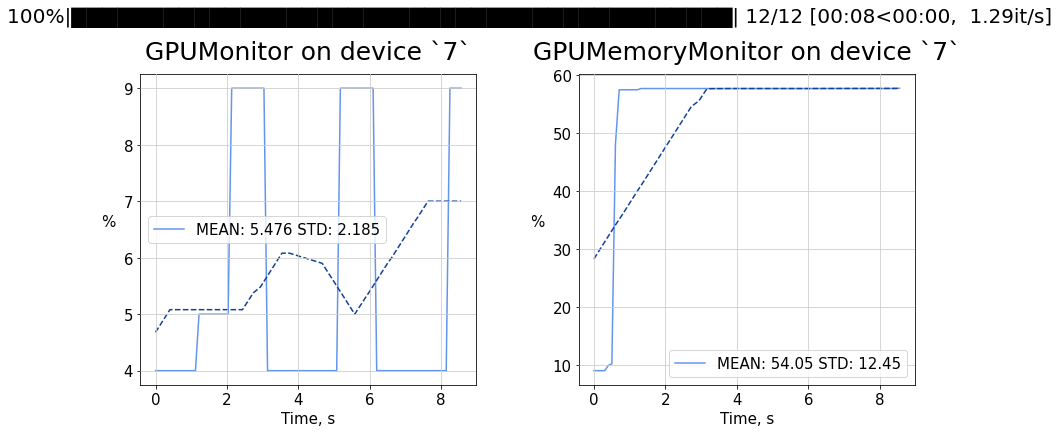

In [9]:
model.eval()

embeddings = []
targets = []

notifier = Notifier('t', graphs=['gpu', 'gpu_memory'])

for batch in notifier(loader):
    inputs = batch['input_tensors'].to(DEVICE)
    batch_embeddings = model(inputs).detach().cpu().numpy()
    embeddings.append(batch_embeddings)
    targets.append(batch['labels'])
    
embeddings = np.vstack(embeddings)
targets = np.hstack(targets)

Now lets fit a K-Nearest Neighbors alogrithm on train subset of embeddings.

In [10]:
from sklearn.decomposition import PCA

In [11]:
N_COMPONENTS = 40
pca = PCA(n_components=N_COMPONENTS)
features = pca.fit_transform(embeddings)

In [12]:
train_features, test_features, train_targets, test_targets = train_test_split(features, targets, test_size=0.2, random_state=SEED)

N_NEIGHBORS = 40
nn = NearestNeighbors(n_neighbors=N_NEIGHBORS)
nn = nn.fit(train_features)

That little buddy will help us to calculate number of most frequent neighbours row-wise.

In [13]:
def bincount_2d(arr, n):
    offsets = arr + np.arange(arr.shape[0])[:, None] * n
    counts = np.bincount(offsets.ravel(), minlength=arr.shape[0] * n)
    counts = counts.reshape(-1, n)
    return counts

Determine neighbours for test subset samples, find most frequent ones, use their class as predition.

In [14]:
_, test_neighbors_indices = nn.kneighbors(test_features)
test_neighbors = train_targets[test_neighbors_indices]
test_predictions = bincount_2d(test_neighbors, n_classes).argmax(axis=1)

Evaluate metrics on our prediction. God, they're good!

,precision,recall
ArtDeco,42.9,30.0
Cubism,72.0,84.3
Impressionism,64.4,65.9
Japonism,67.7,60.0
Naturalism,73.9,64.2
Rococo,54.1,69.0
cartoon,61.5,50.0
photo,87.5,75.0


,accuracy,f1_score
altogether,68.4,63.9


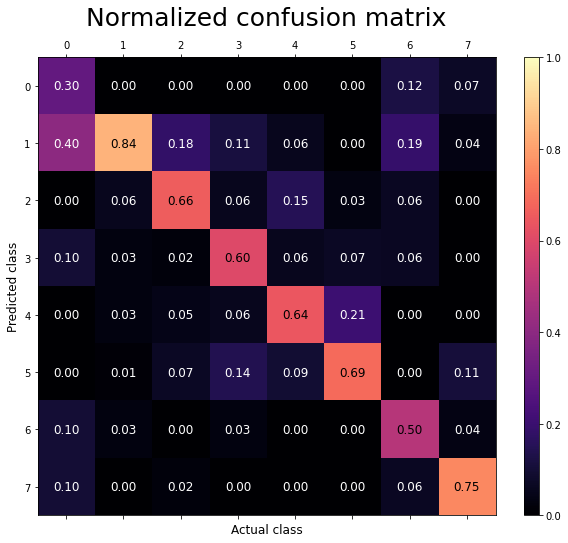

In [15]:
METRICS_PATH = f'../metrics/{NAME}.json'
test_metrics = MetricsEvaluator(test_targets, test_predictions, classes=classes)
test_metrics_dict = test_metrics.evaluate_classification_metrics(savepath=METRICS_PATH)

Save metrics for future evaluation.